# Предсказание цены машины с пробегом

Нам нужно построить модель для определения стоимости автомобилей. 
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Чтобы изучить данные таблиц, сделать необходимые рассчёты и провести исследование сразу импортируем библиотеки, который нам потребуются в данном проекте:

In [1]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

### Загрузим данные и изучим их

Напишем функцию, которая будет отображать основные показатели датасета и строить корреляционную матрицу

In [2]:
def df_info(df):
    """Изучение датасета"""
    print('\nПервые 10 строчек датафрейма')
    display(df.head(10))
    print('\nИнформация о датафрейме\n')
    display(df.info())
    print('\nРасчёт значений в каждом столбце')
    display(df.describe())
    print('\nКоличество дубликатов =', df.duplicated().sum())
    print('\nЧисло пропусков в каждом столбце')
    display(df.isna().sum())
    print('\nПостроение корреляционной матрицы')
    plt.figure(figsize=(12,12))
    corr_matrix = sns.heatmap(df.corr(), annot=True)
    corr_matrix.axes.set_title("\nКорреляционная матрица", fontsize=5)

Прочитаем файл и сохраним его

In [3]:
df = pd.read_csv('C:\\Users\\Дмитрий\\github\\projects\\projects\\Prediction of the price of a car with mileage\\autos.csv') 

Изучим датасет


Первые 10 строчек датафрейма


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

None


Расчёт значений в каждом столбце


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество дубликатов = 4

Число пропусков в каждом столбце


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Построение корреляционной матрицы


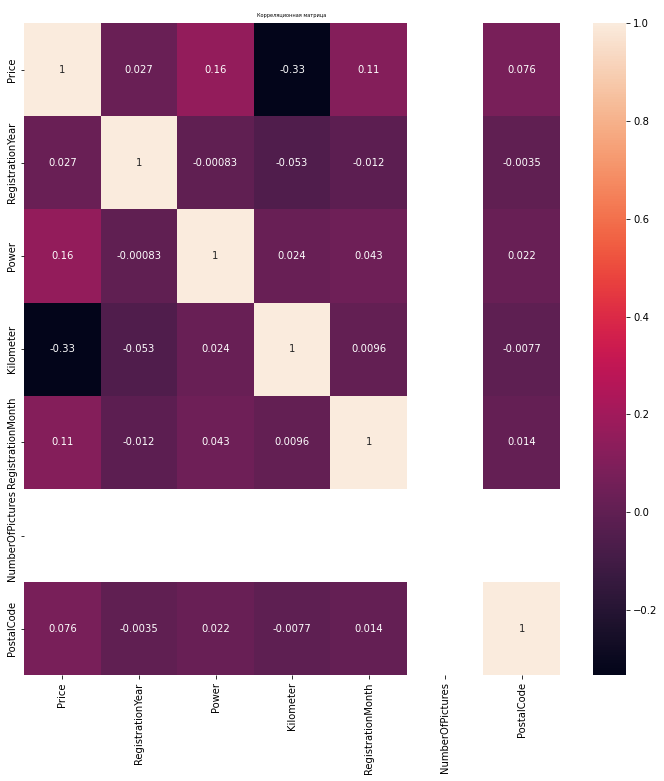

In [4]:
df_info(df)

В таблице 354369 строк и 16 столбцов. Типы данных в столбцах - int64, object.
<br><br>Согласно документации данные можно описать так:
<br><br>Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

<br>Целевой признак

* Price — цена (евро)

**Вывод**
<br><br>В данных встречаются дубликаты и пропуски. Признаки между собой не коррелируют.
<br>Некоторые признаки не пригодятся для обучения моделей.
<br>В целевом признаке встречаются нули, хотя такого значения быть не может.
<br>Устраним проблемы в данных.

### Удалим признаки, которые не пригодятся для обучения моделей

При изучении данных было обнаружено, что признак `NumberOfPictures` содержит только 0. Следовательно можно смело удалять, тк он не повлияет на модель предсказания цены авто.
<br>Данные о дате и времени скачивания анкеты из базы, создания объявления и последней активности пользователя тоже не повлияют на модель предсказания цены авто. Следовательно можно удалять признаки: `DateCrawled, DateCreated, LastSeen`
<br>Данные о почтовом индексе владельца анкеты и месяце покупки машины не влияет на цену машины. Удалим признаки `RegistrationMonth, PostalCode`. 

In [5]:
df = df.drop(['NumberOfPictures','DateCrawled','DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1)

Изучим датасет без признаков не нужных для обучения модели предсказания цены авто


Первые 10 строчек датафрейма


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None


Расчёт значений в каждом столбце


,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000



Количество дубликатов = 45040

Число пропусков в каждом столбце


Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64


Построение корреляционной матрицы


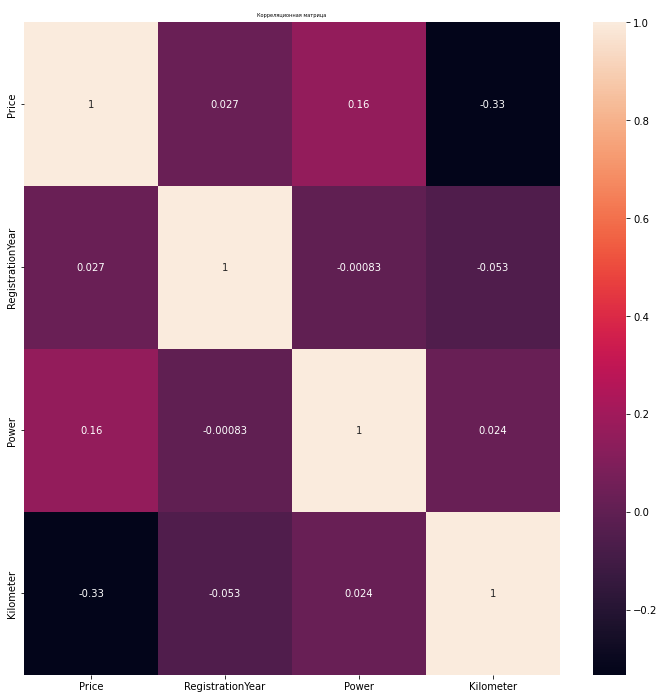

In [6]:
df_info(df)

**Вывод**
<br><br>Удалив лишние признаки мы видим, что число дубликатов  значительно увеличилось, тк видимо одни анкеты загружали из базы по несколько раз в разное время. 
<br>Продолжим устранять проблемы в данных.

### Удалим дубликаты и заменим пропуски

Удалим явные дубликаты

In [7]:
df = df.drop_duplicates()

Посмотрим какие значения и в каком количестве присутствуют в столбцах с категориальными  признаками, чтобы определиться чем можно заменить пропуски

In [8]:
print('VehicleType')
display(df['VehicleType'].value_counts())
display(df['VehicleType'].unique())
print('Gearbox')
display(df['Gearbox'].value_counts())
display(df['Gearbox'].unique())
print('Model')
display(df['Model'].value_counts())
display(df['Model'].unique())
print('FuelType')
display(df['FuelType'].value_counts())
display(df['FuelType'].unique())
print('NotRepaired')
display(df['NotRepaired'].value_counts())
display(df['NotRepaired'].unique())

VehicleType


sedan          78206
small          67548
wagon          56367
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: VehicleType, dtype: int64

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Gearbox


manual    232774
auto       59348
Name: Gearbox, dtype: int64

array(['manual', 'auto', nan], dtype=object)

Model


golf                  23639
other                 22934
3er                   16700
polo                  10494
corsa                  9738
                      ...  
kalina                    7
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: Model, Length: 250, dtype: int64

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

FuelType


petrol      187848
gasoline     84794
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: FuelType, dtype: int64

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

NotRepaired


no     211328
yes     33443
Name: NotRepaired, dtype: int64

array([nan, 'yes', 'no'], dtype=object)

Заменить пропуски в категориальных признаках на какие-то подходящие значения логически не удаётся.
Заменим пропуски в категориальных признаках на `unknown`.

In [9]:
df = df.fillna('unknown')

Изучим датасет без дубликатов и пропусков


Первые 10 строчек датафрейма


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             309329 non-null  int64 
 1   VehicleType       309329 non-null  object
 2   RegistrationYear  309329 non-null  int64 
 3   Gearbox           309329 non-null  object
 4   Power             309329 non-null  int64 
 5   Model             309329 non-null  object
 6   Kilometer         309329 non-null  int64 
 7   FuelType          309329 non-null  object
 8   Brand             309329 non-null  object
 9   NotRepaired       309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


None


Расчёт значений в каждом столбце


,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000



Количество дубликатов = 0

Число пропусков в каждом столбце


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64


Построение корреляционной матрицы


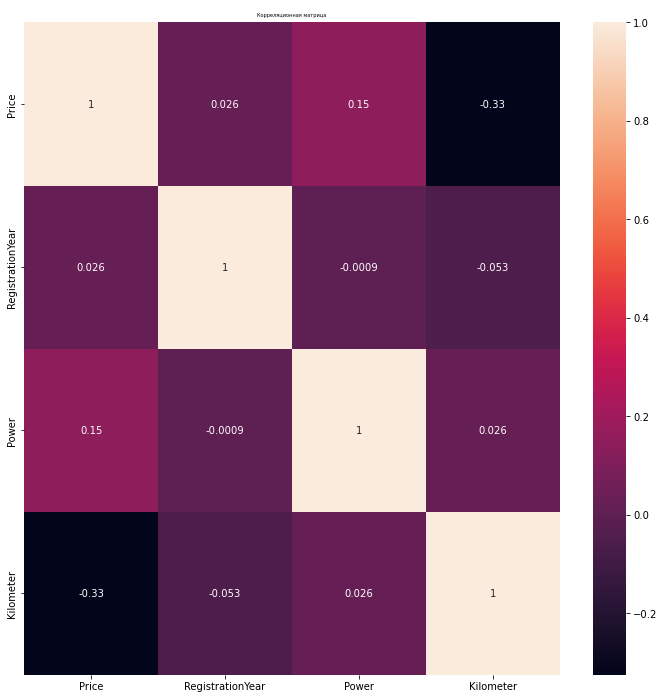

In [10]:
df_info(df)

**Вывод**
<br><br>Мы удалили дубликаты и заменили пропуски. 
<br>Теперь посмотрим распределения количественных признаков.
<br>Продолжим устранять проблемы в данных.

### Посмотрим аномалии в количественных признаках и устраним проблемы в данных

Посмотрим расчёт значений в каждом столбце

In [11]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Напишем функцию для изучения каждого столбца

In [12]:
def graph(Column, n, bins, x1 , x2):
    display(df[df[Column] < n])
            
    df[Column].hist(bins=bins, range=(x1, x2), figsize=(7, 7))
    plt.xlabel(Column, fontsize=10)
    plt.ylabel(r'Quantity', fontsize=10)
    plt.title(Column, fontsize=16)
    plt.show()

**Посмотрим на аномалии в столбце 'RegistrationYear'**

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
622,0,unknown,1111,unknown,0,unknown,5000,unknown,opel,unknown
1794,12800,coupe,1965,manual,90,other,100000,petrol,ford,no
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no
2262,6500,convertible,1965,auto,360,unknown,150000,petrol,sonstige_autos,unknown
...,...,...,...,...,...,...,...,...,...,...
352529,10000,sedan,1961,manual,80,other,125000,petrol,volvo,no
352709,15990,coupe,1964,auto,250,other,5000,petrol,chevrolet,no
353531,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,unknown
353961,200,unknown,1910,unknown,0,unknown,5000,petrol,sonstige_autos,unknown


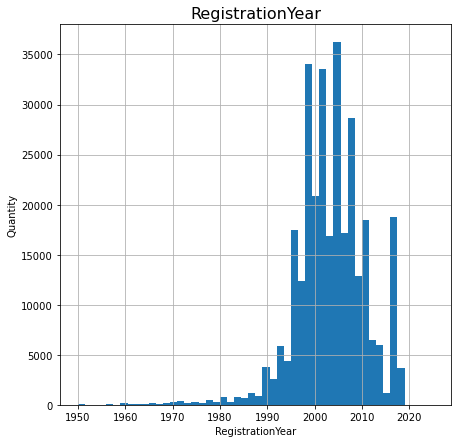

In [13]:
graph('RegistrationYear', 1967, 50, 1950 , 2025)

Посмотрим сколько значений регистрации авто больше 2017 года

In [14]:
df[df['RegistrationYear'] > 2017].count()

Price               3825
VehicleType         3825
RegistrationYear    3825
Gearbox             3825
Power               3825
Model               3825
Kilometer           3825
FuelType            3825
Brand               3825
NotRepaired         3825
dtype: int64

Удалим аномальные значения с датой регистрации авто ранее 1968 года и позже 2017 года, тк таких значений мало по сравнению со всем датафреймом

In [15]:
df = df[(df['RegistrationYear'] > 1967) & (df['RegistrationYear'] <= 2017)]

**Посмотрим на аномалии в столбце 'Price'**

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
16,300,unknown,2016,unknown,60,polo,150000,petrol,volkswagen,unknown
23,450,small,1997,manual,50,arosa,150000,petrol,seat,no
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354318,400,wagon,1991,manual,0,legacy,150000,petrol,subaru,unknown
354329,350,small,1996,unknown,65,punto,150000,unknown,fiat,unknown
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown


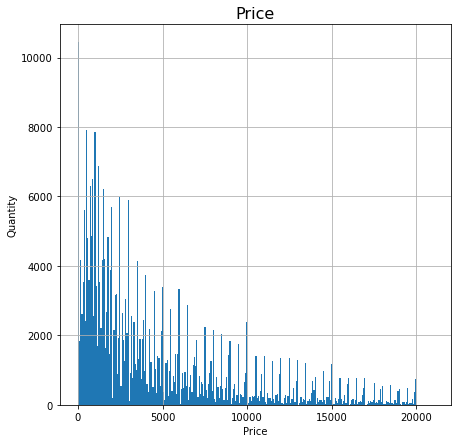

In [16]:
graph('Price', 500, 300, -10 , 21000)

Удалим аномальные значения с ценой менее 500 Евро за авто, тк по данным avto.ru машину иностранного производства можно купить минимум за такую сумму

In [17]:
df = df[df['Price'] >= 500]

**Посмотрим на аномалии в столбце 'Power'**

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
69,1200,coupe,2001,unknown,0,astra,150000,unknown,opel,unknown
70,800,small,1993,manual,0,polo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354305,3500,unknown,1995,unknown,0,polo,150000,unknown,volkswagen,unknown
354332,7900,bus,2007,manual,0,b_klasse,125000,petrol,mercedes_benz,no
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no


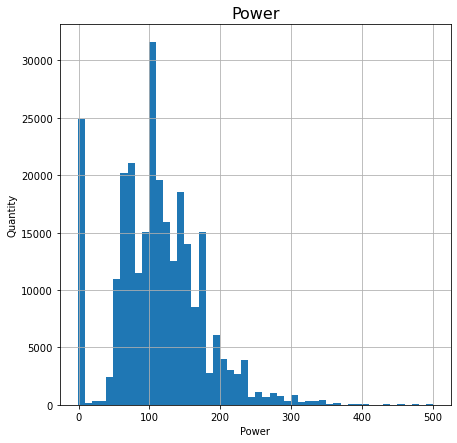

In [18]:
graph('Power', 33, 50, -1 , 500)

По данным объявлений на avto.ru - https://auto.ru/nahabino/cars/all/?displacement_from=200&displacement_to=1000&sort=price-asc наименьшая мощность у машины Ока 33 л.с.
<br> Посмотрим сколько анамально больших значений мощности более 1100 л.с., тк таких машин в мире выпускалось крайне мало

In [19]:
df[df['Power'] > 1100].count()

Price               215
VehicleType         215
RegistrationYear    215
Gearbox             215
Power               215
Model               215
Kilometer           215
FuelType            215
Brand               215
NotRepaired         215
dtype: int64

Удалим аномальные значения с мощностью авто менее 33 л.с и более 1100 л.с.

In [20]:
df = df[(df['Power'] >= 33) & (df['Power'] <= 1100)]

Посмотрим расчёт значений в каждом столбце без выбросов

In [21]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,247286.000000,247286.000000,247286.000000,247286.000000
mean,5193.277282,2003.620144,124.276101,127014.691491
std,4632.092507,6.566741,55.515736,37302.273847
min,500.000000,1968.000000,33.000000,5000.000000
25%,1600.000000,2000.000000,85.000000,125000.000000
50%,3500.000000,2004.000000,116.000000,150000.000000
75%,7499.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2017.000000,1100.000000,150000.000000


Чтобы наглядно увидить как прошла предобработка посмотрим на таблицу корреляции


Первые 10 строчек датафрейма


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247286 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             247286 non-null  int64 
 1   VehicleType       247286 non-null  object
 2   RegistrationYear  247286 non-null  int64 
 3   Gearbox           247286 non-null  object
 4   Power             247286 non-null  int64 
 5   Model             247286 non-null  object
 6   Kilometer         247286 non-null  int64 
 7   FuelType          247286 non-null  object
 8   Brand             247286 non-null  object
 9   NotRepaired       247286 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


None


Расчёт значений в каждом столбце


,Price,RegistrationYear,Power,Kilometer
count,247286.000000,247286.000000,247286.000000,247286.000000
mean,5193.277282,2003.620144,124.276101,127014.691491
std,4632.092507,6.566741,55.515736,37302.273847
min,500.000000,1968.000000,33.000000,5000.000000
25%,1600.000000,2000.000000,85.000000,125000.000000
50%,3500.000000,2004.000000,116.000000,150000.000000
75%,7499.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2017.000000,1100.000000,150000.000000



Количество дубликатов = 0

Число пропусков в каждом столбце


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64


Построение корреляционной матрицы


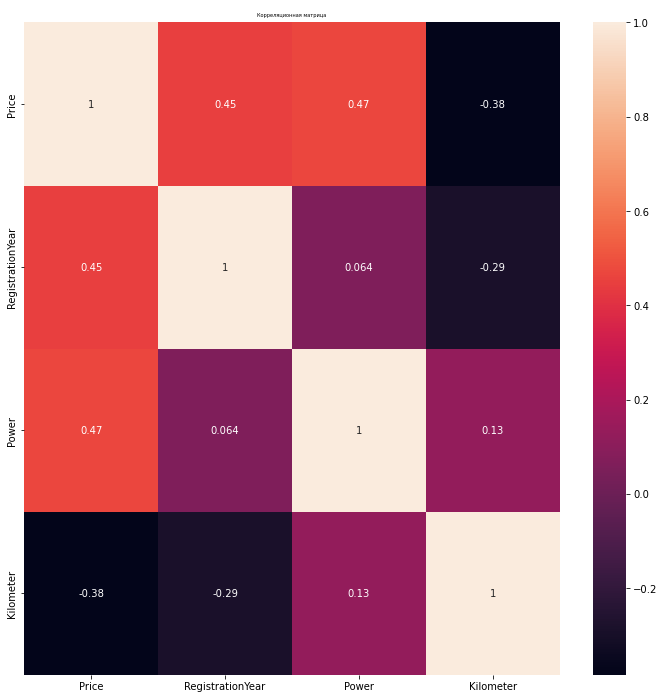

In [22]:
df_info(df)

In [23]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
Price,1.000000,0.243656,0.637122,0.267428,0.446345,0.558700,0.311720,0.224764,0.336906,0.286564
VehicleType,0.243656,1.000000,0.495539,0.361875,0.314282,0.897493,0.277465,0.405723,0.591711,0.337788
RegistrationYear,0.637122,0.495539,1.000000,0.112886,0.190903,0.619880,0.394121,0.298623,0.328604,0.220625
Gearbox,0.267428,0.361875,0.112886,1.000000,0.423659,0.621927,0.078568,0.186295,0.519538,0.251852
Power,0.446345,0.314282,0.190903,0.423659,1.000000,0.629368,0.092033,0.188339,0.489730,0.067972
Model,0.558700,0.897493,0.619880,0.621927,0.629368,1.000000,0.448627,0.525941,0.997775,0.246482
Kilometer,0.311720,0.277465,0.394121,0.078568,0.092033,0.448627,1.000000,0.174059,0.270346,0.222620
FuelType,0.224764,0.405723,0.298623,0.186295,0.188339,0.525941,0.174059,1.000000,0.287096,0.185022
Brand,0.336906,0.591711,0.328604,0.519538,0.489730,0.997775,0.270346,0.287096,1.000000,0.105178
NotRepaired,0.286564,0.337788,0.220625,0.251852,0.067972,0.246482,0.222620,0.185022,0.105178,1.000000


**Вывод**
<br><br>Мы удалили признаки, которые не влияют на цену машины.
<br>Мы удалили дубликаты и заменили пропуски. 
<br>Мы удалили или заменили аномальные значения.

### Преобразование категориальных признаков в численные

Преобразуем значения стобцов `VehicleType, Gearbox, Model, FuelType, Brand NotRepaired` в числа и удалим первый столбец, чтобы избежать дамми-ловушки:

In [24]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head(10)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14500,2014,125,30000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,999,1998,101,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
10,2000,2004,105,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11,2799,2005,140,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Вывод**
<br><br>
Мы преобразовали все категориальные столбцы в таблице и теперь таблица состоит только из чисел.

### Разобьём данные на выборки

Сделаем 3 выборки - обучающую, валидационную и тестовую в пропорциях 60%, 20% и 20% соответственно.
<br>Для этого разделим весь датасет сначала в пропорциях 80% к 20%, а потом полученные 80% разделим на 75% и 25%, чтобы пропорции первого датасета были были 3:1:1.

In [25]:
train_valid, test = train_test_split(df_ohe, test_size=0.2, random_state=12345) 
train, valid = train_test_split(train_valid, test_size=0.25, random_state=12345)

Разделим учебную, валидационные и тестовые выборки на признаки и цели

In [26]:
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']
features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']
features_test = test.drop(['Price'], axis=1)
target_test = test['Price']

**Вывод**

Мы разделили датасет на три выборки:
* обучающую, чтобы обучить модели
* валидационную, чтобы проверять модель на переобучение
* тестовую, чтобы правильно оценить готовую модель

### Масштабируем признаки

Масштабируем признаки, чтобы алгоритм не решил, что признаки с большими значениями и разбросом важнее:

In [27]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display('Размер обучающей выборки', features_train.shape)
display('Размер валидационной выборки', features_valid.shape)
display('Размер тестовой выборки', features_test.shape)
features_train.head(10)

'Размер обучающей выборки'

(148371, 310)

'Размер валидационной выборки'

(49457, 310)

'Размер тестовой выборки'

(49458, 310)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
82897,-1.004530,0.462718,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197025,-1.004530,0.462718,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94132,0.061361,0.336386,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40634,-0.395449,-0.620121,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113393,-0.699990,0.462718,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
247788,-2.070421,-0.890831,0.614111,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36722,1.888603,-0.620121,0.614111,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
83394,1.736333,-0.692310,-3.142571,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
185615,1.888603,-1.342013,0.614111,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
18237,-0.852260,-0.205033,0.614111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**Вывод**
<br><br>
Мы масштабировали признаки, теперь алгоритм не посчитает какие-то значения важнее из-за величины или разброса.
<br>Данные подготовлены, можно приступать к исследованию.

## Обучение моделей

### Обучающее дерево

Посмотрим на какой глубине дерева оптимально будет работать модель и будет выдавать наилучшее значение RMSE

In [28]:
%%time

best_model_tree = None
best_result_mean_squared_error = 1000000000
for i in range(1, 15):
    model_tree = DecisionTreeClassifier(max_depth = i, class_weight='balanced', random_state=12345) # зададим параметры модели обучающего дерева
    model_tree.fit(features_train, target_train) # обучаем модель на учебной выборке
    predictions_valid = model_tree.predict(features_valid) # проверим предсказания модели на валидационных признаках
    result_mean_squared_error = mean_squared_error(target_valid, predictions_valid)
    if result_mean_squared_error < best_result_mean_squared_error: # выберем наилучшее значение метрики f1_score
        best_result_mean_squared_error = result_mean_squared_error 
        best_model_tree = model_tree

print("MSE наилучшей модели на валидационной выборке:", best_result_mean_squared_error)
print("Средняя ошибка модели (RMSE):", best_result_mean_squared_error**0.5)
print("Наилучшая модель с параметрами:", best_model_tree)  

MSE наилучшей модели на валидационной выборке: 24288211.150676344
Средняя ошибка модели (RMSE): 4928.307128282118
Наилучшая модель с параметрами: DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345)
Wall time: 46.8 s


**Вывод**

На модели Обучающее дерево с глубиной 3 и со взвешиванием классов показатели качества модели получилсь следующими:
* RMSE наилучшей модели на валидационной выборке: 24288211
* Средняя ошибка модели: 4928
* Наилучшая модель с параметрами: DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345)

### Случайный лес

Посмотрим на какой глубине дерева и с каким числом деревьев оптимально будет работать модель и будет выдавать наилучшее значение RMSE

In [29]:
%%time

best_model_forest = None
best_result_mean_squared_error_forest = 1000000000
for est in range(1, 20, 5): # переберём с помощью цикла значения деревьев от 1 до 100
    for i in range(1, 15, 5): # переберём с помощью цикла значения глубины деревьева от 1 до 15
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = i, class_weight='balanced') # зададим параметры модели случайный лес
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        result_mean_squared_error_forest = mean_squared_error(target_valid, predictions_forest)
        if result_mean_squared_error_forest < best_result_mean_squared_error_forest: # выберем наилучшее значение метрики f1_score
            best_result_mean_squared_error_forest = result_mean_squared_error_forest 
            best_model_forest = model_forest

print("MSE наилучшей модели на валидационной выборке:", best_result_mean_squared_error_forest)
print("Средняя ошибка модели(RMSE):", best_result_mean_squared_error_forest**0.5)
print("Наилучшая модель с параметрами:", best_model_forest)

MSE наилучшей модели на валидационной выборке: 21365968.014901835
Средняя ошибка модели(RMSE): 4622.333611380926
Наилучшая модель с параметрами: RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1,
                       random_state=12345)
Wall time: 2min 37s


**Вывод**

На модели Случайныёй лес с числом деревьев 1 и с глубиной 6 со взвешиванием классов, показатели качества модели получилсь следующими:
* MSE наилучшей модели на валидационной выборке: 21365968
* Средняя ошибка модели(RMSE): 4622
* Наилучшая модель с параметрами: RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1, random_state=12345)

### Линейная регрессия 

Посмотрим какой результат RMSE выдаст модель

In [30]:
%%time

model_linear = LinearRegression() 
model_linear.fit(features_train, target_train) 
predictions_linear = model_linear.predict(features_valid)
result_linear = mean_squared_error(target_valid, predictions_linear)
            
print("MSE наилучшей модели на валидационной выборке:", result_linear)
print("Средняя ошибка модели(RMSE):", result_linear**0.5)

MSE наилучшей модели на валидационной выборке: 6752156.541077169
Средняя ошибка модели(RMSE): 2598.4912047334637
Wall time: 4.77 s


**Вывод**

На модели Линейная регрессия, показатели качества модели получилсь следующими:
* MSE наилучшей модели на валидационной выборке: 6752156
* Средняя ошибка модели (RMSE): 2598

### CatBoost

Посмотрим какой результат RMSE выдаст модель с параметрами `loss_function="RMSE", iterations=200, random_state=12345`

In [31]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=200, random_state=12345)
model_cat.fit(features_train, target_train, verbose=20) 
predictions_cat = model_cat.predict(features_valid)
result_cat = mean_squared_error(target_valid, predictions_cat)
            
print("MSE наилучшей модели на валидационной выборке:", result_cat)
print("Средняя ошибка модели(RMSE):", result_cat**0.5)

Learning rate set to 0.333822
0:	learn: 3724.0967791	total: 209ms	remaining: 41.5s
20:	learn: 1877.8020446	total: 523ms	remaining: 4.45s
40:	learn: 1778.3300624	total: 798ms	remaining: 3.09s
60:	learn: 1726.1098452	total: 1.06s	remaining: 2.42s
80:	learn: 1691.3817048	total: 1.32s	remaining: 1.95s
100:	learn: 1666.8887695	total: 1.59s	remaining: 1.56s
120:	learn: 1645.9971960	total: 1.86s	remaining: 1.22s
140:	learn: 1627.9603396	total: 2.13s	remaining: 891ms
160:	learn: 1614.0118808	total: 2.39s	remaining: 579ms
180:	learn: 1602.2884886	total: 2.66s	remaining: 279ms
199:	learn: 1590.9224786	total: 2.91s	remaining: 0us
MSE наилучшей модели на валидационной выборке: 2735517.3988543316
Средняя ошибка модели(RMSE): 1653.9399622883327
Wall time: 5.04 s


Посмотрим какой результат RMSE выдаст модель с параметрами `loss_function="RMSE", iterations=1000, depth=10 , random_state=12345`

In [32]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=1000, depth=10 , random_state=12345)
model_cat.fit(features_train, target_train, verbose=50) 
predictions_cat = model_cat.predict(features_valid)
result_cat = mean_squared_error(target_valid, predictions_cat)
            
print("MSE наилучшей модели на валидационной выборке:", result_cat)
print("Средняя ошибка модели(RMSE):", result_cat**0.5)

Learning rate set to 0.09021
0:	learn: 4341.6615800	total: 34.5ms	remaining: 34.5s
50:	learn: 1806.9898984	total: 1.75s	remaining: 32.6s
100:	learn: 1706.5243946	total: 3.46s	remaining: 30.8s
150:	learn: 1653.7340116	total: 5.16s	remaining: 29s
200:	learn: 1619.1147368	total: 6.86s	remaining: 27.3s
250:	learn: 1591.5319732	total: 8.54s	remaining: 25.5s
300:	learn: 1569.2260948	total: 10.2s	remaining: 23.8s
350:	learn: 1549.8704222	total: 11.9s	remaining: 22.1s
400:	learn: 1532.9903816	total: 13.6s	remaining: 20.3s
450:	learn: 1517.5801594	total: 15.3s	remaining: 18.6s
500:	learn: 1503.8481430	total: 17s	remaining: 16.9s
550:	learn: 1491.8915711	total: 18.7s	remaining: 15.2s
600:	learn: 1480.5801168	total: 20.4s	remaining: 13.6s
650:	learn: 1470.6801354	total: 22.1s	remaining: 11.9s
700:	learn: 1461.0406926	total: 23.9s	remaining: 10.2s
750:	learn: 1452.0005850	total: 25.7s	remaining: 8.52s
800:	learn: 1443.3097417	total: 27.5s	remaining: 6.84s
850:	learn: 1434.5754085	total: 29.4s	rema

**Вывод**

На модели CatBoost, лучшие показатели качества модели получилсь на модели с такими параметрами:
* CatBoostRegressor(loss_function="RMSE", iterations=1000, depth=10 , random_state=12345)
* MSE наилучшей модели на валидационной выборке: 2502232
* Средняя ошибка модели(RMSE): 1582

### LightGBM

Посмотрим какой результат RMSE выдаст модель с параметрами `n_estimators=50, class_weight='balanced', random_state=12345`

In [33]:
%%time

model_lgbm = LGBMRegressor(n_estimators=50, class_weight='balanced', random_state=12345)
model_lgbm.fit(features_train, target_train) 
predictions_lgbm = model_lgbm.predict(features_valid)
result_lgbm = mean_squared_error(target_valid, predictions_lgbm)
            
print("MSE наилучшей модели на валидационной выборке:", result_lgbm)
print("Средняя ошибка модели(RMSE):", result_lgbm**0.5)

MSE наилучшей модели на валидационной выборке: 3770953.9735866366
Средняя ошибка модели(RMSE): 1941.8944290528866
Wall time: 1.93 s


Посмотрим какой результат RMSE выдаст модель с параметрами `n_estimators=100, num_leaves=20, class_weight='balanced', random_state=12345`

In [34]:
%%time

model_lgbm = LGBMRegressor(n_estimators=100, num_leaves=20, class_weight='balanced', random_state=12345)
model_lgbm.fit(features_train, target_train) 
predictions_lgbm = model_lgbm.predict(features_valid)
result_lgbm = mean_squared_error(target_valid, predictions_lgbm)
            
print("MSE наилучшей модели на валидационной выборке:", result_lgbm)
print("Средняя ошибка модели(RMSE):", result_lgbm**0.5)

MSE наилучшей модели на валидационной выборке: 3629765.6657066196
Средняя ошибка модели(RMSE): 1905.1943905299058
Wall time: 1.78 s


**Вывод**

На модели LightGBM, лучшие показатели качества модели получилсь на модели с такими параметрами:
* LGBMRegressor(n_estimators=100, num_leaves=20, class_weight='balanced', random_state=12345)
* MSE наилучшей модели на валидационной выборке:3629765
* Средняя ошибка модели(RMSE): 1905

## Анализ моделей

Сравним на тестовой выборке 5 наших обученных моделей с гиперпараметрами на которых были лучшие показатели RMSE 

### Обучающее дерево

Измеряем время обучения модели

In [35]:
%%time

model_tree_test = DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345)
model_tree_test.fit(features_train, target_train)

Wall time: 1.32 s


DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345)

Измеряем время предсказания модели и смотрим результат RMSE на тестовой выбоке

In [36]:
%%time

predictions_tree_test = model_tree_test.predict(features_test) 
result_mean_squared_error_tree_test = mean_squared_error(target_test, predictions_tree_test)

print("MSE наилучшей модели на валидационной выборке:", result_mean_squared_error_tree_test)
print("Средняя ошибка модели(RMSE):", result_mean_squared_error_tree_test**0.5)

MSE наилучшей модели на валидационной выборке: 24295791.111104373
Средняя ошибка модели(RMSE): 4929.076091023993
Wall time: 738 ms


### Случайный лес

Измеряем время обучения модели

In [37]:
%%time

model_forest_test = RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1, random_state=12345)
model_forest_test.fit(features_train, target_train)

Wall time: 565 ms


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1,
                       random_state=12345)

Измеряем время предсказания модели и смотрим результат RMSE на тестовой выбоке

In [38]:
%%time

predictions_forest_test = model_forest_test.predict(features_test) 
result_mean_squared_error_forest_test = mean_squared_error(target_test, predictions_forest_test)

print("MSE наилучшей модели на валидационной выборке:", result_mean_squared_error_forest_test)
print("Средняя ошибка модели(RMSE):", result_mean_squared_error_forest_test**0.5)

MSE наилучшей модели на валидационной выборке: 21250811.829350155
Средняя ошибка модели(RMSE): 4609.86028306175
Wall time: 2.1 s


### Линейная регрессия 

Измеряем время обучения модели

In [39]:
%%time

model_linear_test = LinearRegression()
model_linear_test.fit(features_train, target_train)

Wall time: 4.3 s


LinearRegression()

Измеряем время предсказания модели и смотрим результат RMSE на тестовой выбоке

In [40]:
%%time

predictions_linear_test = model_linear_test.predict(features_test) 
result_mean_squared_error_linear_test = mean_squared_error(target_test, predictions_linear_test)

print("MSE наилучшей модели на валидационной выборке:", result_mean_squared_error_linear_test)
print("Средняя ошибка модели(RMSE):", result_mean_squared_error_linear_test**0.5)

MSE наилучшей модели на валидационной выборке: 6745685.961161776
Средняя ошибка модели(RMSE): 2597.245841494751
Wall time: 98.9 ms


### CatBoost

Измеряем время обучения модели

In [41]:
%%time

model_cat_test = CatBoostRegressor(loss_function="RMSE", iterations=1000, depth=10 , random_state=12345)
model_cat_test.fit(features_train, target_train, verbose=100)

Learning rate set to 0.09021
0:	learn: 4341.6615800	total: 36.8ms	remaining: 36.8s
100:	learn: 1706.5243946	total: 3.5s	remaining: 31.1s
200:	learn: 1619.1147368	total: 6.89s	remaining: 27.4s
300:	learn: 1569.2260948	total: 10.3s	remaining: 23.8s
400:	learn: 1532.9903816	total: 13.6s	remaining: 20.3s
500:	learn: 1503.8481430	total: 17s	remaining: 16.9s
600:	learn: 1480.5801168	total: 20.3s	remaining: 13.5s
700:	learn: 1461.0406926	total: 23.6s	remaining: 10.1s
800:	learn: 1443.3097417	total: 27s	remaining: 6.7s
900:	learn: 1426.5636777	total: 30.3s	remaining: 3.33s
999:	learn: 1411.4552273	total: 33.6s	remaining: 0us
Wall time: 34.5 s


Измеряем время предсказания модели и смотрим результат RMSE на тестовой выбоке

In [42]:
%%time

predictions_cat_test = model_cat_test.predict(features_test)
result_cat_test = mean_squared_error(target_test, predictions_cat_test)
            
print("MSE наилучшей модели на валидационной выборке:", result_cat_test)
print("Средняя ошибка модели(RMSE):", result_cat_test**0.5)

MSE наилучшей модели на валидационной выборке: 2475137.5259367623
Средняя ошибка модели(RMSE): 1573.2569802599835
Wall time: 291 ms


### LightGBM

Измеряем время обучения модели

In [43]:
%%time

model_lgbm_test = LGBMRegressor(n_estimators=100, num_leaves=20, class_weight='balanced', random_state=12345)
model_lgbm_test.fit(features_train, target_train) 

Wall time: 1.5 s


LGBMRegressor(class_weight='balanced', num_leaves=20, random_state=12345)

Измеряем время предсказания модели и смотрим результат RMSE на тестовой выбоке

In [44]:
%%time

predictions_lgbm_test = model_lgbm_test.predict(features_test)
result_lgbm_test = mean_squared_error(target_test, predictions_lgbm_test)
            
print("MSE наилучшей модели на валидационной выборке:", result_lgbm_test)
print("Средняя ошибка модели(RMSE):", result_lgbm_test**0.5)

MSE наилучшей модели на валидационной выборке: 3628977.122535482
Средняя ошибка модели(RMSE): 1904.9874336949003
Wall time: 306 ms


## Вывод

Отобразим полученные результаты по 5 исследуемым моделям обучения в виде таблицы, где отобразим необходимые параметры для заказчика:
* качество предсказания (RMSE);
* скорость предсказания;
* время обучения.

In [45]:
result_data = {'CatBoost': [1573, 0.25, 45.1],
              'LightGBM': [1904, 0.5, 55],
              'Линейная регрессия': [2597, 0.11, 16.78],
              'Случайный лес': [4609, 2.65, 0.42],
              'Обучающее дерево': [4929, 0.54, 0.9],}
result_researches = pd.DataFrame(data=result_data, index=['Средняя ошибка модели(RMSE)', 'Cкорость предсказания', 'Время обучения']) 
result_researches

,CatBoost,LightGBM,Линейная регрессия,Случайный лес,Обучающее дерево
Средняя ошибка модели(RMSE),1573.00,1904.0,2597.00,4609.00,4929.00
Cкорость предсказания,0.25,0.5,0.11,2.65,0.54
Время обучения,45.10,55.0,16.78,0.42,0.90


Наилучший результат качества - средняя ошибка модели(RMSE) у модели CatBoostRegressor(loss_function="RMSE", iterations=1000, depth=10 , random_state=12345), скорость предсказания у неё тоже очень высокая, но долгое время обучения.
<br><br>Второй результат по качеству у модели LGBMRegressor(n_estimators=100, num_leaves=20, class_weight='balanced', random_state=12345), скорость предсказания и время обучения немного выше, чем у лучшей модели по качеству.
<br><br>Третий результат по качеству у модели LinearRegression(), хотя качество уже значительно хуже, чем у лучшей модели по качеству, скорость предсказания самая быстрая, но время обучения тоже значительное.
<br><br>Моделей RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1, random_state=12345) и DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345) качество хуже модели CatBoost в почти в 3 раза.
<br><br>Самой оптимальной моделью для поставленной задачи считаю CatBoost, тк результат качества самый высокий, время предсказания второе по скорости, а время обучение не столь большое, чтобы отказываться от первый двух более значительных плюсов.